# Figure Out Which Employees May Quit

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Reading HR Data
file_name = "../hr_data.csv"
hr_df = pd.read_csv(file_name)
hr_df.head()



,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,1003,2,157,3,0,1,0,sales,low
1,1005,5,262,6,0,1,0,sales,medium
2,1486,7,272,4,0,1,0,sales,medium
3,1038,5,223,5,0,1,0,sales,low
4,1057,2,159,3,0,1,0,sales,low


In [3]:
# Details of values
print('Details:\n',hr_df.describe())
print('Info:', hr_df.info())
print('----------------------------------------------------------------------------------------------------------------')

#No of Rows
print('No of Rows:', hr_df.shape)
print('----------------------------------------------------------------------------------------------------------------')

# View which columns are categorical
print('Categorical Columns: \n', hr_df.select_dtypes(exclude=['int64', 'float']).columns)
#hr_df.info()


Details:
         employee_id  number_project  average_montly_hours  time_spend_company  \
count  14999.000000    14999.000000          14999.000000        14999.000000   
mean   45424.627575        3.803054            201.050337            3.498233   
std    25915.900127        1.232592             49.943099            1.460136   
min     1003.000000        2.000000             96.000000            2.000000   
25%    22872.500000        3.000000            156.000000            3.000000   
50%    45448.000000        4.000000            200.000000            3.000000   
75%    67480.500000        5.000000            245.000000            4.000000   
max    99815.000000        7.000000            310.000000           10.000000   

       Work_accident          left  promotion_last_5years  
count   14999.000000  14999.000000           14999.000000  
mean        0.144610      0.238083               0.021268  
std         0.351719      0.425924               0.144281  
min         0.000000

In [4]:
# Display unique values in categorical columns
print(hr_df['department'].unique())
print(hr_df['salary'].unique())

['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
['low' 'medium' 'high']


In [5]:
# Reading Employee Satisfaction Data
emp_sat_file = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/employee_satisfaction_evaluation.xlsx"
emp_satis_eval = pd.read_excel(emp_sat_file)
emp_satis_eval.head()

,EMPLOYEE #,satisfaction_level,last_evaluation
0,1003,0.38,0.53
1,1005,0.80,0.86
2,1486,0.11,0.88
3,1038,0.72,0.87
4,1057,0.37,0.52


In [6]:
emp_satis_eval.shape

(14999, 3)

In [7]:
# Merging/Joining Employee data and satisfaction data
merged_emp_data = hr_df.set_index('employee_id').join(emp_satis_eval.set_index('EMPLOYEE #'))
merged_emp_data = merged_emp_data.reset_index()
merged_emp_data

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,satisfaction_level,last_evaluation
0,1003,2,157,3,0,1,0,sales,low,0.38,0.53
1,1005,5,262,6,0,1,0,sales,medium,0.80,0.86
2,1486,7,272,4,0,1,0,sales,medium,0.11,0.88
3,1038,5,223,5,0,1,0,sales,low,0.72,0.87
4,1057,2,159,3,0,1,0,sales,low,0.37,0.52
...,...,...,...,...,...,...,...,...,...,...,...
14994,87670,2,151,3,0,1,0,support,low,0.40,0.57
14995,87673,2,160,3,0,1,0,support,low,0.37,0.48
14996,87679,2,143,3,0,1,0,support,low,0.37,0.53
14997,87681,6,280,4,0,1,0,support,low,0.11,0.96


In [8]:
null_val_rows = merged_emp_data[merged_emp_data.isnull().any(axis=1)]

In [9]:
def find_median_val(row):
    #breakpoint()
    min_time_spend = 0 if (row.time_spend_company -1) <= 0 else (row.time_spend_company -1)
    min_avg_monthly = 0 if (row.average_montly_hours -20) <= 0 else (row.average_montly_hours -20)
    all_rows = merged_emp_data[(merged_emp_data.department == row.department) 
                               & (merged_emp_data.salary == row.salary)
                               & (merged_emp_data.left == row.left)
                               & ((merged_emp_data.time_spend_company >= min_time_spend) & (merged_emp_data.time_spend_company <= row.time_spend_company+1))
                               & ((merged_emp_data.average_montly_hours >= min_avg_monthly) & (merged_emp_data.average_montly_hours >= row.average_montly_hours+20))]
    
    
    if (len(all_rows.mode()['last_evaluation']) > 0):
        last_evaluation_mode = all_rows.mode()['last_evaluation'][0]
    else:
        last_evaluation_mode = merged_emp_data.mode()['last_evaluation'][0]
        
    if (len(all_rows.mode()['satisfaction_level']) > 0):
        satisfaction_level_mode = all_rows.mode()['satisfaction_level'][0]
    else:
        satisfaction_level_mode = merged_emp_data.mode()['last_evaluation'][0]
    
    return last_evaluation_mode,satisfaction_level_mode

In [10]:
for index, row in null_val_rows.iterrows():
    last_eval, satis_val = find_median_val(row)
    
    if (math.isnan(row['last_evaluation'])):
        merged_emp_data.loc[index, 'last_evaluation'] = last_eval
    
    if (math.isnan(row['satisfaction_level'])):
        merged_emp_data.loc[index, 'satisfaction_level'] = satis_val

In [11]:
merged_emp_data.groupby('department').sum()

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,satisfaction_level,last_evaluation
department,,,,,,,,,
IT,56344929,4683,248119,4256,164,273,3,757.67,879.30
RandD,32948168,3033,158030,2650,134,121,27,487.80,560.57
accounting,34474313,2934,154292,2702,96,204,14,446.18,550.83
hr,31664725,2701,146828,2480,89,215,15,442.15,523.91
management,33597098,2432,126787,2711,103,91,69,391.41,456.24
marketing,40715777,3164,171073,3063,138,203,43,530.25,613.78
product_mng,44016858,3434,180369,3135,132,198,0,558.61,644.62
sales,192072490,15634,831773,14631,587,1014,100,2540.81,2938.39
support,97874011,8479,447490,7563,345,555,20,1377.02,1611.45


In [12]:
merged_emp_data.groupby('department').mean()

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,satisfaction_level,last_evaluation
department,,,,,,,,,
IT,45920.887531,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445,0.617498,0.716626
RandD,41865.524778,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307,0.619822,0.712287
accounting,44946.953064,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253,0.581721,0.718162
hr,42848.071719,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298,0.598309,0.708945
management,53328.726984,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524,0.621286,0.724190
marketing,47454.285548,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117,0.618007,0.715361
product_mng,48799.177384,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000,0.619302,0.714656
sales,46394.321256,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155,0.613722,0.709756
support,43909.381337,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973,0.617775,0.722948


In [13]:
merged_emp_data['department'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

In [14]:
merged_emp_data['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

# Displaying Correlation Matrix

In [15]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.legend('Correlation Matrix')
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

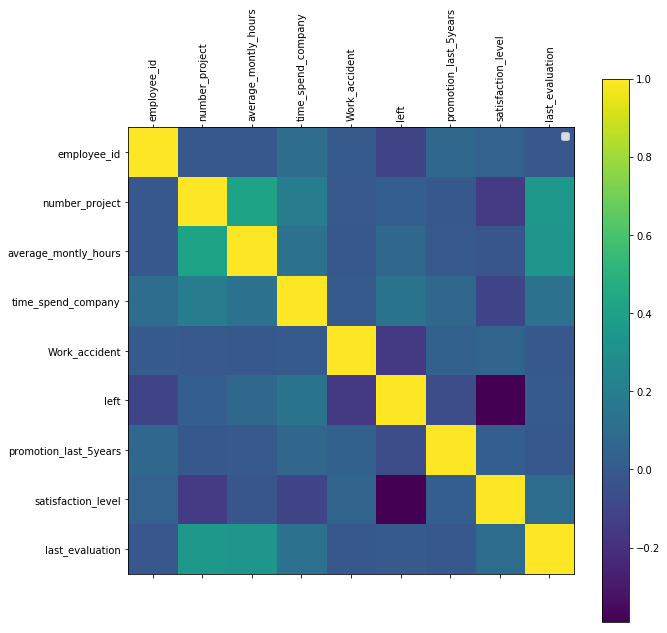

In [16]:
plot_corr(merged_emp_data)

# Preparing out Dataset for ML

In [17]:
# Perform One Hot Encoding on Categorical Data

categorial = ['department','salary']
main_df_final = pd.get_dummies(merged_emp_data, columns=categorial, drop_first=True)
main_df_final.head()

,employee_id,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,satisfaction_level,last_evaluation,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,1003,2,157,3,0,1,0,0.38,0.53,0,0,0,0,0,0,1,0,0,1,0
1,1005,5,262,6,0,1,0,0.80,0.86,0,0,0,0,0,0,1,0,0,0,1
2,1486,7,272,4,0,1,0,0.11,0.88,0,0,0,0,0,0,1,0,0,0,1
3,1038,5,223,5,0,1,0,0.72,0.87,0,0,0,0,0,0,1,0,0,1,0
4,1057,2,159,3,0,1,0,0.37,0.52,0,0,0,0,0,0,1,0,0,1,0


In [18]:
# How many employees in the dataset have left?

len(main_df_final.loc[main_df_final['left'] == 1])

3571

## Preparing our Dataset for Machine Learning

In [19]:
X = main_df_final.drop(['left'],axis=1)
Y = main_df_final['left']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)

In [20]:
# Normalize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Logistic Regression Model

Accuracy 79.67%


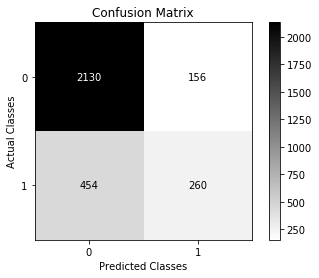

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2286
           1       0.62      0.36      0.46       714

    accuracy                           0.80      3000
   macro avg       0.72      0.65      0.67      3000
weighted avg       0.78      0.80      0.78      3000



In [21]:
from pycm import ConfusionMatrix

from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions, y_test)))
cm = ConfusionMatrix(y_test.values.squeeze(), predictions)
cm.plot(number_label=True)
plt.show()
print(classification_report(y_test, predictions))

## Random Forest Model

98.56666666666666
Accuracy 98.57%


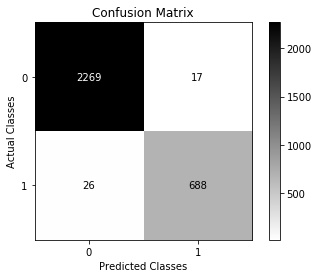

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.96      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
score = model.score(X_test, y_test)

print(score*100)
print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions, y_test)))
cm = ConfusionMatrix(y_test.values.squeeze(), predictions)
cm.plot(number_label=True)
plt.show()
print(classification_report(y_test, predictions))

In [23]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = pd.DataFrame(X_train).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances

,importance
6,0.262152
0,0.245304
3,0.138363
1,0.119457
2,0.110510
7,0.091925
4,0.006851
17,0.006368
18,0.003308
16,0.003041


## Deep Learning

In [24]:
# Use the newest version of TensorFlow 2.0
%tensorflow_version 2.x 

UsageError: Line magic function `%tensorflow_version` not found.


In [25]:
model = Sequential()

model.add(Dense(9, kernel_initializer = "uniform", activation = "relu", input_dim=19))
model.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))

model.compile(optimizer= "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

# Display Model Summary and Show Parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 180       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Start Training Our Classifier 
batch_size = 10
epochs = 25

#X_train = X_train.reshape(-1,19*11999)
#X_test = X_test.reshape(-1,19*3000)

history = model.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
1200/1200 [==============================] - 2s 1ms/step - loss: 0.5170 - accuracy: 0.7679 - val_loss: 0.2942 - val_accuracy: 0.8320
Epoch 2/25
1200/1200 [==============================] - 1s 715us/step - loss: 0.2817 - accuracy: 0.8428 - val_loss: 0.2305 - val_accuracy: 0.9277
Epoch 3/25
1200/1200 [==============================] - 1s 703us/step - loss: 0.2218 - accuracy: 0.9362 - val_loss: 0.2033 - val_accuracy: 0.9537
Epoch 4/25
1200/1200 [==============================] - 1s 731us/step - loss: 0.2019 - accuracy: 0.9505 - val_loss: 0.1882 - val_accuracy: 0.9553
Epoch 5/25
1200/1200 [==============================] - 1s 698us/step - loss: 0.1831 - accuracy: 0.9541 - val_loss: 0.1795 - val_accuracy: 0.9567
Epoch 6/25
1200/1200 [==============================] - 1s 694us/step - loss: 0.1903 - accuracy: 0.9540 - val_loss: 0.1755 - val_accuracy: 0.9580
Epoch 7/25
1200/1200 [==============================] - 1s 706us/step - loss: 0.1754 - accuracy: 0.9551 - val_loss: 0.1695 - v

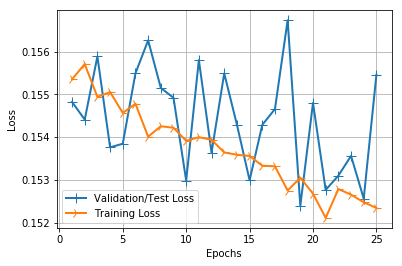

In [28]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

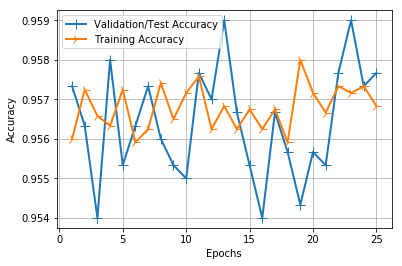

In [29]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Displaying the Classification Report and Confusion Matrix

In [42]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[2226   60]
 [  67  647]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2286
           1       0.92      0.91      0.91       714

    accuracy                           0.96      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.96      0.96      0.96      3000



## More Deeper Model

In [46]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

model2 = Sequential()

# Hidden Layer 1
model2.add(Dense(270, activation='relu', input_dim=19, kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))

# Hidden Layer 1
model2.add(Dense(180, activation='relu', input_dim=19, kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))

# Hidden Layer 2
model2.add(Dense(90, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3, noise_shape=None, seed=None))

model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 270)               5400      
_________________________________________________________________
dropout_3 (Dropout)          (None, 270)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 180)               48780     
_________________________________________________________________
dropout_4 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 90)                16290     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 91        
Total params: 70,561
Trainable params: 70,561
Non-trainable params: 0
__________________________________________________

In [47]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
batch_size = 10
epochs = 25

history = model2.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
1200/1200 [==============================] - 2s 1ms/step - loss: 1.2240 - accuracy: 0.8660 - val_loss: 0.2649 - val_accuracy: 0.9523
Epoch 2/25
1200/1200 [==============================] - 2s 1ms/step - loss: 0.2708 - accuracy: 0.9436 - val_loss: 0.2455 - val_accuracy: 0.9433
Epoch 3/25
1200/1200 [==============================] - 2s 2ms/step - loss: 0.2439 - accuracy: 0.9489 - val_loss: 0.2349 - val_accuracy: 0.9460
Epoch 4/25
1200/1200 [==============================] - 2s 1ms/step - loss: 0.2260 - accuracy: 0.9485 - val_loss: 0.2053 - val_accuracy: 0.9587
Epoch 5/25
1200/1200 [==============================] - 2s 1ms/step - loss: 0.2307 - accuracy: 0.9524 - val_loss: 0.2126 - val_accuracy: 0.9513
Epoch 6/25
1200/1200 [==============================] - 2s 1ms/step - loss: 0.2238 - accuracy: 0.9484 - val_loss: 0.2034 - val_accuracy: 0.9607
Epoch 7/25
1200/1200 [==============================] - 2s 2ms/step - loss: 0.2188 - accuracy: 0.9521 - val_loss: 0.2043 - val_accuracy:

In [49]:
predictions = model2.predict(X_test)
predictions = (predictions > 0.5)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[2237   49]
 [  70  644]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2286
           1       0.93      0.90      0.92       714

    accuracy                           0.96      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.96      0.96      0.96      3000

